In [45]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [46]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)} # String to Int
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # Int to String
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Generating context and labels

In [50]:
def build_dataset(words):


    block_size = 3 # context length of characters taken to predict the next 
    X, Y = [],[]

    for w in words:
        
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '------>', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words)) 
Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [5]:
#X.shape, X.dtype, Y.shape, Y.dtype

In [6]:
#X

In [7]:
#Y

In [8]:
C = torch.randn((27, 2))

In [9]:
C#[5]

tensor([[-0.5887, -0.2846],
        [ 0.0666, -2.4799],
        [ 0.8984, -0.9443],
        [-1.3043,  0.2748],
        [-0.5579,  0.2814],
        [-0.0492, -0.5195],
        [ 0.0298, -0.9609],
        [ 1.0481,  1.0210],
        [-0.5627, -0.8225],
        [-2.1913, -0.4884],
        [ 1.9844,  0.2142],
        [-0.2905,  0.2953],
        [ 0.6125, -0.6467],
        [ 1.5775, -0.8531],
        [ 0.6937, -0.8097],
        [ 1.7635,  0.3525],
        [-2.2906,  1.0458],
        [ 0.4738, -0.3540],
        [ 0.2929,  0.5853],
        [ 0.6825,  0.4231],
        [-0.9619,  1.8854],
        [-0.5942,  0.4269],
        [-1.4056, -1.1731],
        [-1.3344,  0.2535],
        [-2.1666, -0.3389],
        [ 0.7830, -2.0633],
        [ 0.2367, -0.8563]])

In [10]:
emb = C[Xtrain]
#emb.shape

In [11]:
w1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [12]:
# cat concatonates along the given dimension and unbind returns a tuple of slices 
# along the given dimension, this is less efficient than using view
#  torch.cat(torch.unbind(emb, 1), 1).shape

In [13]:
a = torch.arange(18)
#a

In [14]:
#a.view(2, 3, 3)

In [15]:
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
#h

In [16]:
#b1.shape

In [17]:
# checking the broadcasting of b and the result of emb @ w1
# 32, 100
# 1 , 100

In [18]:
w2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [19]:
logits = h @ w2 + b2
#logits.shape

In [20]:
counts = logits.exp()

In [21]:
prob = counts/counts.sum(1, keepdims=True)
#prob.shape

In [22]:
#prob[torch.arange(32), Y]

In [23]:
#Y

# Making it more respecatble

In [52]:
Xtrain.shape, Ytrain.shape

(torch.Size([182424, 3]), torch.Size([182424]))

In [112]:
g = torch.Generator().manual_seed(2147483647)
c = torch.randn((27, 10), generator=g)
w1 = torch.randn((30, 200), generator=g)
b1 = torch.randn((200), generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [c, w1, b1, w2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


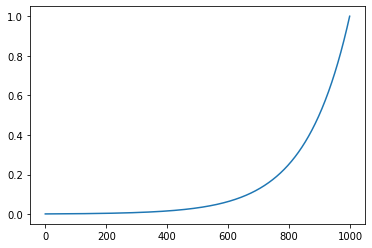

In [113]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
plt.plot(lrs)

In [114]:
lri = []
lossi = []
stepi = []

In [120]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtrain.shape[0], (64,))
    # forward pass
    emb = c[Xtrain[ix]]
    h = torch.tanh(emb.view(-1, 30) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Ytrain[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.01 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr  * p.grad
    # track stats
    lossi.append(loss.log10().item())
    stepi.append(i)




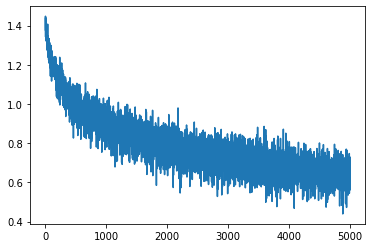

In [116]:
plt.plot(stepi, lossi)

In [117]:
emb = c[Xtrain]
h = torch.tanh(emb.view(-1, 30) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Ytrain)
loss

tensor(4.2848, grad_fn=<NllLossBackward0>)

In [118]:
emb = c[Xdev]
h = torch.tanh(emb.view(-1, 30) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Ydev)
loss


tensor(4.3586, grad_fn=<NllLossBackward0>)

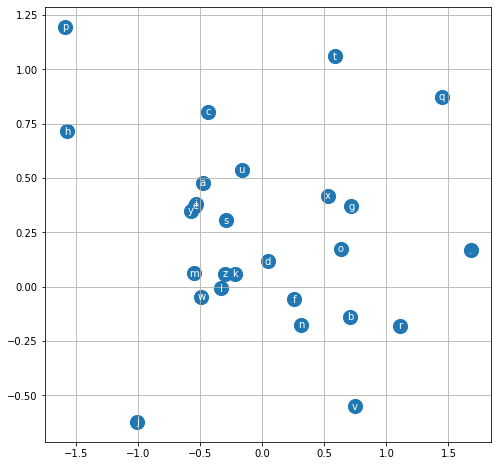

In [119]:
plt.figure(figsize=(8, 8))
plt.scatter(c[:,0].data, c[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(c[i,0].item(),c[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [121]:
g = torch.Generator().manual_seed(2147483647+ 10)
block_size = 3
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = c[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))


carmahzamille.
khiimili.
thha.
halaysa.
jazonen.
deliyra.
kaqui.
nerinistchaiir.
kaleig.
hham.
por.
debinn.
sroja.
alian.
quisathon.
jaryxi.
jacee.
ivuli.
edye.
iia.


tensor([ 5, 13, 13,  ..., 26, 24,  0])